In [38]:
import os, sys
import numpy as np
import pandas as pd
from PIL import Image
from ast import literal_eval
from dataclasses import dataclass
from datasets import load_dataset

import torch
import torch.nn as nn
from transformers import (
    GPT2Model, GPT2Tokenizer,
    
    CLIPVisionModel, CLIPProcessor,
    
    TrainingArguments, Trainer,
    
    logging, set_seed
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == "cuda":
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 3090


In [44]:
dataset = load_dataset(
    "csv",
    data_files={
        "train": "../CLIP-GPT2/data/clip-gpt2/train_nolabel.csv",
        "test": "../CLIP-GPT2/data/clip-gpt2/test_nolabel.csv"
    }
)
'''
dataset = dataset.map(
    lambda examples: {
        'label' : [
            literal_eval(l)
            for l in examples['label']
        ]
    }, batched=True
)
'''

Using custom data configuration default-b9aef813a733952b
Found cached dataset csv (C:/Users/Keenan Samway/.cache/huggingface/datasets/csv/default-b9aef813a733952b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

"\ndataset = dataset.map(\n    lambda examples: {\n        'label' : [\n            literal_eval(l)\n            for l in examples['label']\n        ]\n    }, batched=True\n)\n"

In [45]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'caption'],
        num_rows: 1184167
    })
    test: Dataset({
        features: ['image_id', 'caption'],
        num_rows: 131575
    })
})

In [4]:
def showExample(id=None):
    data = dataset["test"]
    
    if id is None:
        id = torch.randint(len(data['image_id']), size=(1,)).item()
    
    img = Image.open(os.path.join("../datasets/AVA/images", data[id]['image_id']))
    print("Caption:", data[id]['caption'])
    print("Label:", data[id]['label'])
    display(img)
    

Caption: the photo of you is great. i love the expression of the face which seems to be fitting with the rest of the photo. one thing that i don't like about it and you explain that you printed it on a transparency is that you can see parts of the background if you look carefully. i'm not sure what your reasoning was to print on a transparency but i think regular paper would have worked well too.
Label: [1169, 4590, 286, 345, 318, 1049, 13, 1312, 1842, 262, 5408, 286, 262, 1986, 543, 2331, 284, 307, 15830, 351, 262, 1334, 286, 262, 4590, 13, 530, 1517, 326, 1312, 836, 470, 588, 546, 340, 290, 345, 4727, 326, 345, 10398, 340, 319, 257, 13902, 318, 326, 345, 460, 766, 3354, 286, 262, 4469, 611, 345, 804, 7773, 13, 1312, 1101, 407, 1654, 644, 534, 14607, 373, 284, 3601, 319, 257, 13902, 475, 1312, 892, 3218, 3348, 561, 423, 3111, 880, 1165, 13]


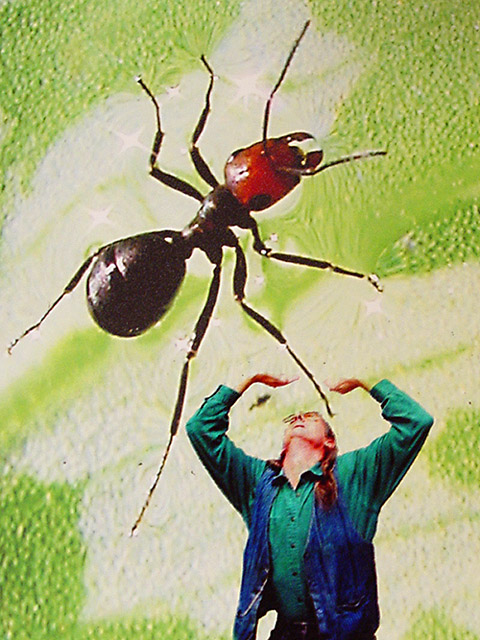

In [6]:
showExample()

In [63]:
@dataclass
class MyCollator:
    tokenizer: GPT2Tokenizer
    processor: CLIPProcessor
        
    def tokenize_text(self, texts):
        eos = self.tokenizer.eos_token
        texts = [eos + x + eos for x in texts]
        
        encoded_text = self.tokenizer(
            texts,
            padding="longest",
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text["input_ids"].squeeze(),
            "attention_mask": encoded_text["attention_mask"].squeeze(),
        }
        
    def process_image(self, images):
        processed_images = self.processor(
            images=[Image.open(os.path.join("..", "datasets/AVA/images", image_id)).convert('RGB') for image_id in images],
            return_tensors="pt",
            )
        return {
            "pixel_values": processed_images["pixel_values"].squeeze(),
        }
    
    def __call__(self, raw_batch_dict):        
        return {
            **self.tokenize_text(
                raw_batch_dict['caption']
                if isinstance(raw_batch_dict, dict) else
                [i['caption'] for i in raw_batch_dict]
            ),
            **self.process_image(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            # 'labels': torch.tensor(
            #     raw_batch_dict['label']
            #     # if isinstance(raw_batch_dict, dict) else
            #     # [i['label'] for i in raw_batch_dict]
            #     , dtype=torch.int64
            # ),
        }

In [6]:
class MultimodalFusionModel(nn.Module):
    def __init__(self, text_model, image_model, vocab_size, embed_dim=512, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.text_model = text_model
        self.image_model = image_model
        
        # Pretrained transformers for encoding text and image
        with torch.no_grad():
            self.text_encoder = GPT2Model.from_pretrained(text_model)
            self.image_encoder = CLIPVisionModel.from_pretrained(image_model)
                
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size, self.embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        
        self.classifier = nn.Linear(self.embed_dim, self.vocab_size)
        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, 
                pixel_values : torch.FloatTensor,
                input_ids : torch.LongTensor, 
                attention_mask : torch.LongTensor=None,
                caption=None,
                image_id=None):        
        encoded_text = self.text_encoder(input_ids[..., :-1:], attention_mask=attention_mask[..., :-1:], return_dict=True)
        
        encoded_images = self.image_encoder(pixel_values, return_dict=True)
                
        fused_output = self.fusion(
            torch.cat([encoded_text["last_hidden_state"], encoded_images["pooler_output"].unsqueeze(1)], dim=1)
        )
        
        logits = self.classifier(fused_output)
                
        out = {"logits": logits}
        
        loss = None
        if input_ids is not None:
            labels = input_ids.clone()
            # Shift so that tokens < n predict n
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            
            # Flatten tokens
            loss = self.criterion(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            
            #loss = self.criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            out["loss"] = loss
        
        return out

In [13]:
def createCollatorAndModel(text="gpt2", image="openai/clip-vit-base-patch32"):
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    processor = CLIPProcessor.from_pretrained(image)
    
    tokenizer.pad_token = tokenizer.eos_token
    
    mycollator = MyCollator(tokenizer=tokenizer, processor=processor)
    model = MultimodalFusionModel(text, image, tokenizer.vocab_size)
    
    return mycollator, model.to(device)

In [15]:
text_model_type = '../CLIP-GPT2/models/gpt2-small-AVA/checkpoint-20500'
image_model_type = 'openai/clip-vit-base-patch32'

In [14]:
logging.set_verbosity_error()
mycollator, model = createCollatorAndModel(text=text_model_type, image=image_model_type)

In [17]:
args = TrainingArguments(
    output_dir="../CLIP-GPT2/models/clip-gpt2/b32-small",
    seed=42,
    evaluation_strategy="steps",
    eval_steps=1000,
    logging_strategy="steps",
    logging_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    fp16=True,
    fp16_opt_level="O1",
    # warmup_ratio=0.01,
    # leraning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=0,
    load_best_model_at_end=True,
    disable_tqdm=False,
    dataloader_pin_memory=True,
)
set_seed(42)

In [18]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=mycollator,
)

Using cuda_amp half precision backend


In [ ]:
if __name__ == "__main__":
    trainer.train()

# Inference

In [15]:
text_model_type = '../CLIP-GPT2/models/gpt2-small-AVA/checkpoint-20500'
image_model_type = 'openai/clip-vit-base-patch32'

In [32]:
logging.set_verbosity_error()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = MultimodalFusionModel(text_model_type, image_model_type, tokenizer.vocab_size)
model.load_state_dict(torch.load('../CLIP-GPT2/models/clip-gpt2/b32-small/checkpoint-5000/pytorch_model.bin'))
model.to(device)

MultimodalFusionModel(
  (text_encoder): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropou

In [33]:
sample = mycollator(dataset['test'][2000:2005])

In [34]:
input_ids = sample['input_ids'].to(device)
attention_mask = sample['attention_mask'].to(device)
pixel_values = sample['pixel_values'].to(device)

In [35]:
model.eval()
output = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)

In [36]:
preds = output['logits'].argmax(dim=-1)

-------------------------
Caption: maybe should have added some motion blur, grunge, bunch of actions
Label: [25991, 815, 423, 2087, 617, 6268, 23671, 11, 44397, 469, 11, 7684, 286, 4028]


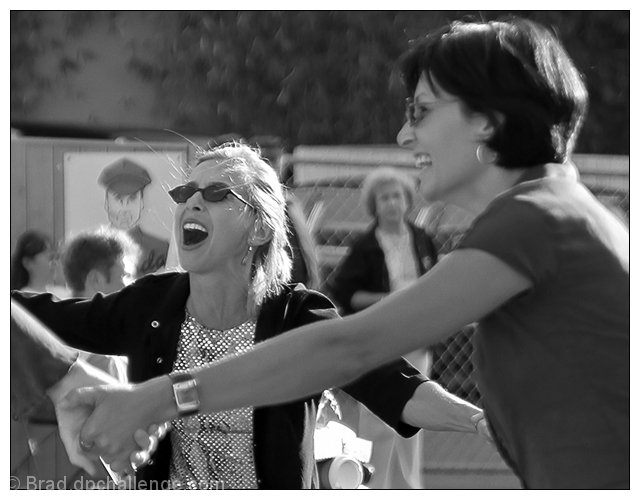

Prediction:  a have cropped a more blur to butgy, or of people,<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> you
-------------------------
-------------------------
Caption: i like it. large fields of different tones spiraling around a red center. plus, you bring the viewer very close to the danger. there's even room on the right for text.
Label: [72, 588, 340, 13, 1588, 7032, 286, 1180, 23755, 9158, 4272, 1088, 257, 2266, 3641, 13, 5556, 11, 345, 2222, 262, 19091, 845, 1969, 284, 262, 3514, 13, 612, 338, 772, 2119, 319, 262, 826, 329, 2420, 13]


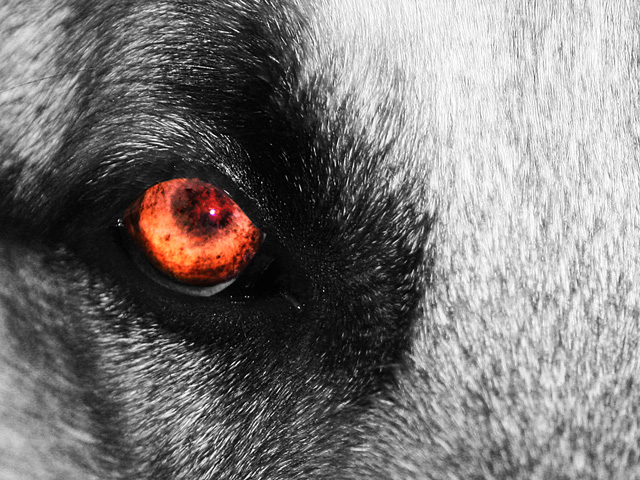

Prediction:  like the. i, of water colors andals off the subject sky.<|endoftext|>, the've out subject into close to the subject.<|endoftext|> is a a for the left to the. a
-------------------------
-------------------------
Caption: the idea is fine, but i don't understand why did u left the photo to be dark and with low contrast
Label: [1169, 2126, 318, 3734, 11, 475, 1312, 836, 470, 1833, 1521, 750, 334, 1364, 262, 4590, 284, 307, 3223, 290, 351, 1877, 6273]


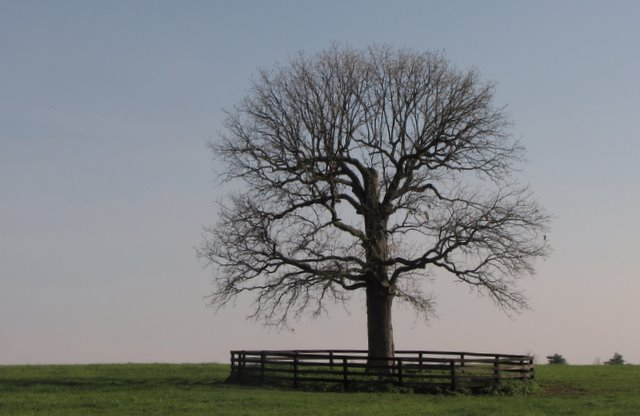

Prediction:  colors is good, but the think't think the you you get the white in be so? dark the contrast?<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> a
-------------------------
-------------------------
Caption: very nice detail and composition. i like all the fuzz on the stem and leaves.
Label: [548, 3621, 3703, 290, 11742, 13, 1312, 588, 477, 262, 26080, 319, 262, 10717, 290, 5667, 13]


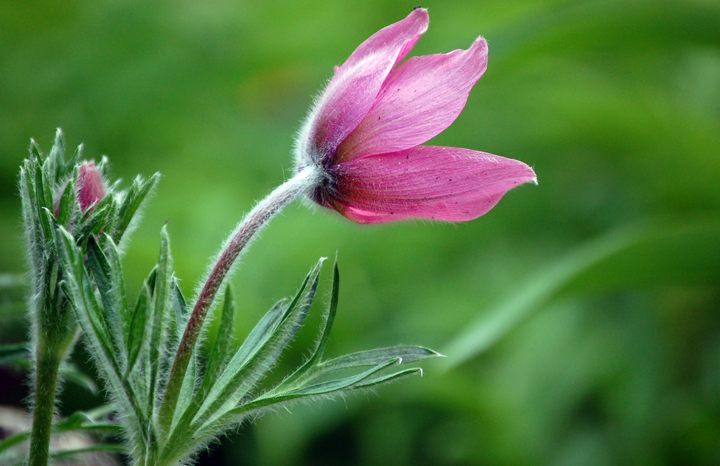

Prediction:  nice. and composition. i like the the linesiness the water. the.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> a
-------------------------
-------------------------
Caption: . i'm speechless on how well you've captured the moment, the place. everything came together perfectly. top !
Label: [13, 1312, 1101, 4046, 1203, 319, 703, 880, 345, 1053, 7907, 262, 2589, 11, 262, 1295, 13, 2279, 1625, 1978, 7138, 13, 1353, 5145]


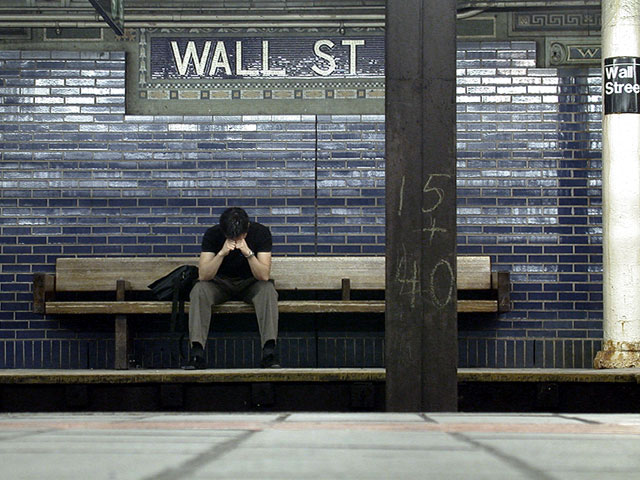

Prediction:  i like notless. this much this did done this mood. but composition,<|endoftext|> else out to.<|endoftext|> ten<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> this
-------------------------


In [37]:
for i in range(2000, 2005):
    print("-------------------------")
    showExample(i)
    print("Prediction:", tokenizer.decode(preds[i-2000].tolist()))
    print("-------------------------")